# SPM Figure 1 - Design Walkthrough

Written by Stuart Jenkins (stuart.jenkins@wadham.ox.ac.uk) and Richard Millar (richard.millar@ouce.ox.ac.uk)

<br>
<br>

## Necessary packages and externally defined functions imported

First we import the necessary packages required for figure creation. Also imported here is the FaIR climate-carbon-cycle model code ('from fair\_scm import *'). For more information on the FaIR model see the paper by Richard Millar et al. (2017) ('A modified impulse-response representation of the global near-surface air temperature and atmospheric concentration response to carbon dioxide emissions' - Atmos. Chem. Phys., 2017).

Also here a colour palette is defined so we can access a named colour 'vermillion' later in the figure.

In [1]:
# External packages required for figure production
# -------------------------------------------------
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.special import erf, erfinv
from statsmodels.api import OLS
import statsmodels.tools.tools
import copy
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.legend_handler import HandlerTuple
# -------------------------------------------------

# Import the FaIR climate-carbon-cycle model from python file
from fair_scm import *

# -------------------------------------------------
# load colour palette for vermillion colour definition (used for historical anthropogenic temperature range)
def load_colpal():
    rgb_list = np.array([[213,94,0]]) / 255.
    rgb_names = ['vermillion']
    rgbs = {rgb_names[x]:tuple(rgb_list[x]) for x in range(0,len(rgb_list))}
    return rgbs

cols = load_colpal()

/Users/stuartjenkins/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<br>
<br>

## Loading historical temperature datasets

First, the datasets we use to define a mean historical temperature observations timeseries are loaded and rebaselined to a common reference period (1850-1900). The chosen datasets are:
- HadCRUT4,
- HadCRUT4-Cowtan-Way,
- NOAA,
- GISTEMP.

The mean of these datasets is found, along with the max/min range. Next, we use the FaIR model with standard parameters and Piers Forsters best estimate climate forcing datasets to find the natural and anthropogenic contributions to this mean-observations temperature timeseries. 

Finally, we use OLS regression to find the best-fit scaling of anthropogenic and natural temperature timeseries to the observations, based on the method of Haustein et al. (2017) ('A real-time Global Warming Index' - Scientific Reports 7, 2017).

In [2]:
# -------------------------------------------------
# -------------------------------------------------
# Import and rebaseline the observations ready for plotting
# -------------------------------------------------
# -------------------------------------------------

# define the baseline year range, and common reference range
base_low=1850.
base_high=1900.
com_ref_low=1880.
com_ref_high=2017.
# define variable representing the frequency of temperature observations data ('mon' = monthly)
temp_freq='mon'

# -------------------------------------------------
## Import the temperature observation datasets ##
#Specify the GMST best-estimate temperature timeseries files to load from
gmst_files = {'HadCRUT4':'./Data/HadCRUT.4.6.0.0.monthly_ns_avg.txt',
'GISTEMP':'./Data/GLB.Ts+dSST.csv',
'NOAA':'./Data/aravg.mon.land_ocean.90S.90N.v4.0.1.201803.asc',
'Cowtan-Way':'./Data/had4_krig_v2_0_0.txt'}

gmst_names = gmst_files.keys()
# make a common years vector, which we can use as the years variable on all imported temperature datasets
years_com = np.arange(1850. + 1./24,1850. + 1./24 + (2020)*1./12,1.0/12)[:-1]

# define dictionary gmst to hold the temperature data and its averages etc.
gmst = {}

# Go through the datasets imported from the files referenced in 'gmst_files' above and load them
for key in gmst_names:
    
    if key in ['HadCRUT4','Cowtan-Way']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,1]
        years = years_com[:len(temps)]

    if key in ['GISTEMP']:
        f_giss = open(gmst_files[key],'r')
        temps = []
        counter = 0
        for line in f_giss:
          if counter>=2:
              temps.extend([float(f) for f in line.split(',')[1:13] if f != '***'])
          counter = counter + 1
        temps=np.array(temps)
        years = years_com[years_com>1880.][:len(temps)]

    if key in ['NOAA']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,2]
        years = years_com[years_com>1880.][:len(temps)]


    gmst[key] = {'Temp':temps,'Years':years}

#Set the datasets to a common reference period        
hc_ref = np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=com_ref_low,
                gmst['HadCRUT4']['Years']<(com_ref_high+1))]) - np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=base_low,
                                                gmst['HadCRUT4']['Years']<(base_high+1))])
for key in gmst_names:
    gmst[key]['Temp'] = gmst[key]['Temp'][gmst[key]['Years'] < 2018.]
    gmst[key]['Years'] = gmst[key]['Years'][gmst[key]['Years'] < 2018.]
    #Express relative to a common base period
    gmst[key]['Temp'] = gmst[key]['Temp'] - np.mean(gmst[key]['Temp'][np.logical_and(gmst[key]['Years']>=com_ref_low,
                                                              gmst[key]['Years']<(com_ref_high+1))])
    #Set NOAA and GISTEMP datasets relative to HadCRUT4 value over the base period 
    if key in ['NOAA','GISTEMP']:
        gmst[key]['Temp'] = gmst[key]['Temp'] + hc_ref
    else: 
        gmst[key]['Temp'] = gmst[key]['Temp'] - np.mean(gmst[key]['Temp'][np.logical_and(gmst[key]['Years']>=base_low,gmst[key]['Years']<(base_high+1))])
# -----------------------------------------------
        
        
# -----------------------------------------------
# -----------------------------------------------
# Find the min, mean and max values from the temperautre observations
# -----------------------------------------------
# -----------------------------------------------

# create vectors to store answers in
obs_max = np.zeros_like(gmst['HadCRUT4']['Years'])
obs_min = np.zeros_like(gmst['HadCRUT4']['Years'])
obs_mean = np.zeros_like(gmst['HadCRUT4']['Years'])
for y in range(0,len(gmst['HadCRUT4']['Years'])): 
    year_vals = []
    #Loop over AR5 datasets and Cowtan-Way
    for ob in ['HadCRUT4','NOAA','GISTEMP','Cowtan-Way']:
        # collect the temperature value at a given year in each dataset and store in val
        val = gmst[ob]['Temp'][gmst[ob]['Years']==gmst['HadCRUT4']['Years'][y]]
        if len(val)>0:
            year_vals.append(val)
    # find the min, mean and max values from each year
    obs_max[y] = np.max(year_vals)
    obs_min[y] = np.min(year_vals)
    obs_mean[y] = np.mean(year_vals)

# save as entries in gmst
gmst['Temp-max'] = obs_max
gmst['Temp-min'] = obs_min
gmst['Temp-mean'] = obs_mean
# -----------------------------------------------


# -----------------------------------------------
# -----------------------------------------------
# Using OLS regression to scale anthropogenic and natural contributions to observed GMST data
# Methodology follows Haustein et al. (Scientific Reports, 2017)
# -----------------------------------------------
# -----------------------------------------------

########################################################################
# define function to complete OLS regression analysis of temperature observations and t_anthro/t_nat
########################################################################
def calc_gwi(obs,obs_years,reg_type='mon',base_low=1850.,base_high=1900):
    
    #Express the observations relative to the base period 
    obs = obs - np.mean(obs[np.logical_and(obs_years>=base_low,obs_years<(base_high+1))])

    #Load the best estimate forcings from Piers
    forc_file = './Data/Annualforcings_Mar2014_GHGrevised.txt'
    data = np.genfromtxt(forc_file,skip_header=4)
    years = data[:,0]
    tot_forc = data[:,13]
    ant_forc = data[:,14]
    
    #Integrate anthropogenic and natural forcing with standard FAIR parameters
    C, t_nat = fair_scm(other_rf=tot_forc-ant_forc)
    C, t_anthro = fair_scm(other_rf=ant_forc)
    #Express relative to the centre of the base period
    t_nat = t_nat - np.mean(t_nat[np.logical_and(years>=base_low,years<base_high+1)])
    t_anthro = t_anthro - np.mean(t_anthro[np.logical_and(years>=base_low,years<base_high+1)])
    # -----------------------------------------------
    
    
    # Prepare the temperatures run through FaIR, so they lie on same year-grid as observations, so they can be compared
    # -----------------------------------------------
    #Interpolate the annual forced responses to the grid of the observed data
    if reg_type !='mon':
        t_nat = np.interp(obs_years+0.5, years+0.5, t_nat)
        t_anthro = np.interp(obs_years+0.5, years+0.5, t_anthro)
    else:
        t_nat = np.interp(obs_years, years+0.5, t_nat)
        t_anthro = np.interp(obs_years, years+0.5, t_anthro)

    #Linearly project the final half year
    t_anthro[obs_years>(years[-1]+0.5)] = 12*(t_anthro[obs_years<=(years[-1]+0.5)][-1] - t_anthro[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_anthro[obs_years<=(years[-1]+0.5)][-1]
    t_nat[obs_years>(years[-1]+0.5)] = 12*(t_nat[obs_years<=(years[-1]+0.5)][-1] - t_nat[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_nat[obs_years<=(years[-1]+0.5)][-1]
    # -----------------------------------------------
    
    #Use scipy defined OLS regression function to complete OLD regression of observations data on natural and anthropogenic warming with a constant
    y = np.copy(obs)
    x = DataFrame({'x1': (t_anthro), 'x2': (t_nat)})
    # add constant vector on to dataframe we will fit to temp observations
    x = statsmodels.tools.tools.add_constant(x)
    # complete OLS regression of anthropogenic and natural temperatures (found from FaIR integrated best estimate forcing) onto given observed temperature dataset.
    model = OLS(y, x)
    result = model.fit()
    # collect output scaling factors for anthro and natural temperature timeseries
    sf = result.params

    #Form scaled anthropgenic warming index
    awi = t_anthro * sf['x1']
    #Scaled natural warming index
    nwi = t_nat * sf['x2']
    #Scaled total externally forced warming index
    gwi = awi + nwi
    
    print sf['x1'], sf['x2']

    return awi, nwi
########################################################################
########################################################################



# calculate the AWI and NWI for each GMST dataset relative to the baseperiod and
#      also for the mean of the datasets 
for key in gmst_names:
    awi, nwi = calc_gwi(gmst[key]['Temp'],gmst[key]['Years'],reg_type=temp_freq,
                        base_low=base_low,base_high=base_high)
    # express AWI and NWI relative the mid-point of the period
    gmst[key]['AWI'] = awi 
    gmst[key]['NWI'] = nwi 

# calculte for the mean of the datasets
awi, nwi = calc_gwi(gmst['Temp-mean'],gmst['HadCRUT4']['Years'],reg_type=temp_freq,
                    base_low=base_low,base_high=base_high)
gmst['Temp-mean-AWI'] = awi 
gmst['Temp-mean-NWI'] = nwi

# -----------------------------------------------


1.00012367606 0.201416324161
0.871077415374 0.451902969412
0.927203660205 0.520981887708
0.952947569001 0.200951175944
0.912621338044 0.395722694204


## Defining the figure shape

Next, we define the shape of the figure, adding axes and preparing these for data to be plotted. We add the historical observed temperature data and plot the best-fit anthropogenic contribution to this, along with a $\pm20\%$ likely plume.

In [3]:
###############################################################################
###############################################################################
# DEFINE THE SPM FIGURE 1 SHAPE
###############################################################################
###############################################################################
                                                                                                    
# define a figure shape - locations and sizes of axes
main_xstart = 0.13; main_xwidth = 0.79; main_ystart = 0.50; main_ywidth = 0.42
left_xstart = 0.13; left_xwidth = 0.23; left_ystart = 0.11; left_ywidth = 0.30
mid_xstart = 0.41; mid_xwidth = 0.23; mid_ystart = 0.11; mid_ywidth = 0.30
right_xstart = 0.69; right_xwidth = 0.23; right_ystart = 0.11; right_ywidth = 0.30

# define the figure
fig = plt.figure(figsize=(12,8))
# define the left subplot
ax_left = fig.add_axes([left_xstart,left_ystart,left_xwidth,left_ywidth])
ax_left.spines['right'].set_visible(False)
ax_left.spines['top'].set_visible(False)
ax_left.tick_params(colors='white')
ax_left.set_xlim(1960,2100)
ax_left.set_xticks([1980,2020,2060,2100],minor = False)
ax_left.set_xticks([1960,2000,2040,2080],minor = True)
ax_left.set_ylim(0,60)
ax_left.set_yticks([0,20,40,60],minor = True)
ax_left.set_yticks([0,10,20,30,40,50,60],minor = False)
left_text = ax_left.text(0.03,1.0,'Annual CO$_{2}$ emissions',fontsize=12,
                         transform=ax_left.transAxes,ha='left',color='white')
# define the middle subplot
ax_middle = fig.add_axes([mid_xstart,mid_ystart,mid_xwidth,mid_ywidth])
ax_middle.spines['right'].set_visible(False)
ax_middle.spines['top'].set_visible(False)
ax_middle.set_xlim(1960,2100)
ax_middle.set_xticks([1980,2020,2060,2100],minor = False)
ax_middle.set_xticks([1960,2000,2040,2080],minor = True)
ax_middle.set_ylim(0,3.5)
ax_middle.set_yticks([0,1,2,3],minor = False)
ax_middle.set_yticks([0.5,1.5,2.5,3.5],minor = True)
ax_middle.tick_params(colors='white')
mid_text = ax_middle.text(0.03,1.0,'Cumulative CO$_{2}$ emissions', 
               fontsize=12,transform=ax_middle.transAxes, 
               ha='left', color='white')
# define the right subplot
ax_right = fig.add_axes([right_xstart,right_ystart,right_xwidth,right_ywidth])
ax_right.spines['right'].set_visible(False)
ax_right.spines['top'].set_visible(False)
ax_right.set_xlim(1960,2100)
ax_right.set_xticks([1980,2020,2060,2100],minor = False)
ax_right.set_xticks([1960,2000,2040,2080],minor = True)
ax_right.set_ylim(0,3.5)
ax_right.set_yticks([0,1,2,3],minor = False)
ax_right.set_yticks([0.5,1.5,2.5,3.5],minor = True)
ax_right.tick_params(colors='white')
right_text = ax_right.text(0.03,1.0,'Non-CO$_{2}$ climate forcing', 
               fontsize=12,transform=ax_right.transAxes, 
               ha='left', color='white')
# define the main subplot
ax_main_fig = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])
ax_main_fig.spines['right'].set_visible(False)
ax_main_fig.spines['top'].set_visible(False)
ax_main_fig.set_xlim(1960,2100)
ax_main_fig.set_ylim(0,2.0)
ax_main_fig.set_yticks([0,0.5,1.0,1.5,2.0],minor=False)
ax_main_fig.set_yticks([0.25,0.75,1.25,1.75],minor=True)
ax_main_fig.set_ylabel(r'Global warming ($^\circ$C) relative to 1850-1900')

# add the lines which make up the historical temperature timeseries data
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-max'],gmst['Temp-min'],
                     color='grey',alpha=0.3)
ax_main_fig.plot(gmst['HadCRUT4']['Years'],np.array(gmst['Temp-mean']),color='grey',
             linestyle='-',linewidth=1, alpha = 0.4)
ax_main_fig.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'], color=cols['vermillion'],
             linestyle='-', linewidth=2)
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-mean-AWI']*(1.2),
                 gmst['Temp-mean-AWI']*(0.8),color=cols['vermillion'],
                 alpha=0.4,linewidth=0)
###############################################################################
###############################################################################
# END OF MAIN FIGURE CREATION
###############################################################################
###############################################################################


########################
# Add historical warming to date and most likely anthropogenic contributions, with likely plume...
########################

# Add a line showing the position of 2017 and current temperature gradient
# ----------------------------------------------- 
warm_end = np.mean(gmst['Temp-mean-AWI'][np.logical_and(np.array(gmst['HadCRUT4']['Years'])>=2017,
                   np.array(gmst['HadCRUT4']['Years'])<2018)])

# add orange dot at 2017 observed temperature value
ax_main_fig.scatter(2017.5,warm_end,s=30,color='orange',zorder=20)

#Add projection for current warming rate 
proj_short = np.arange(2018,2042)
warm_rate = 0.021
ax_main_fig.plot(proj_short+0.5,warm_end+warm_rate*(proj_short+0.5-2017.5),linestyle='--',
                 dashes=(3, 2),color=cols['vermillion'],linewidth=1.5,zorder=10, label='If current warming rate continues')

# add horizontal line at 1.5 degrees and vertical line at 2017 to main axes
ax_main_fig.axhline(y=1.5,linewidth=0.75,linestyle='--',dashes=(3,3),color='grey')
ax_main_fig.text(2015,0.43,'2017',fontsize=10,color='black')
ax_main_fig.plot([2017.5,2017.5],[0,0.40],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
ax_main_fig.plot([2017.5,2017.5],[0.52,warm_end],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')

# aded legend for current warming rate line
legend6 = ax_main_fig.legend(loc='upper left', framealpha=1, edgecolor='black')
# -----------------------------------------------

<br>
<br>

## Calculating the temperature projection plumes

This section is split into 3 subsections, where different key functions are outlined.

- Functions to load and load and prepare forcing and emissions datasets,
- Functions to scale the contributions of non-CO$_2$ forcing components to fit the 2017 GMST temperature likely range,
- Functions to produce the CO$_2$ and non-CO$_2$ future senarios and calculate temperature responses.

### Loading and preparing the data

First we define a number of functions to load and prepare the datasets (eg. radiative forcing scenarios). 

In [4]:
# -----------------------------------------------
# return the timeseries x re-baselined to be zero between the years base_low and base_high.
# -----------------------------------------------
def express_as_anom(x,years,base_low=1861.,base_high=1880.):
    # Inputs are a timeseries (x) and corresponding years, and a baseline period to rebaseline the data to
    # Returns the timeseries (x) rebaselined to the specified reference period
    return x - np.mean(x[np.logical_and(years>=base_low,years<=base_high)])

# -------------------------------------------------------------------- #


# -----------------------------------------------
# load the historical contrails radiative forcing dataset from AR5 data file.
# -----------------------------------------------
def load_contrails_rf(years,datadir='./Data/'):
    
    rf_cont_file = datadir+'ipcc_tod_rftimeseries.txt'
    hist_rf_dat = np.genfromtxt(rf_cont_file,skip_header=4)
    #Contrail forcing assumed to be constant in future as no scenario data 
    rf_cont = 0.05*np.ones_like(years)
    rf_cont[years<=2011] = hist_rf_dat[15:,10]

    return rf_cont

# -------------------------------------------------------------------- #


# -----------------------------------------------
# load the components of the RCP8.5 radiative forcing dataset, 
#     return datasets in arrays of natural forcing contributions and anthropogenic forcing contributions.
# -----------------------------------------------
def load_rf_comps(rf_file,ar5_scale=False):
    """Loads the components of RF from a spreadsheet (.csv) of the different components
    """
    
    # outline the columns layout in the rf data file
    dt = np.dtype({'names':["YEARS","TOTAL_INCLVOLCANIC_RF","VOLCANIC_ANNUAL_RF","SOLAR_RF","TOTAL_ANTHRO_RF","GHG_RF",
    "KYOTOGHG_RF","CO2CH4N2O_RF","CO2_RF","CH4_RF","N2O_RF","FGASSUM_RF","MHALOSUM_RF","CF4","C2F6","C6F14","HFC23","HFC32",
    "HFC43_10","HFC125","HFC134a","HFC143a","HFC227ea","HFC245fa","SF6","CFC_11","CFC_12","CFC_113","CFC_114","CFC_115",
    "CARB_TET","MCF","HCFC_22","HCFC_141B","HCFC_142B","HALON1211","HALON1202","HALON1301","HALON2402","CH3BR","CH3CL",
    "TOTAER_DIR_RF","OCI_RF","BCI_RF","SOXI_RF","NOXI_RF","BIOMASSAER_RF","MINERALDUST_RF","CLOUD_TOT_RF","STRATOZ_RF",
    "TROPOZ_RF","CH4OXSTRATH2O_RF","LANDUSE_RF","BCSNOW_RF"],'formats':54*["f8"]})
    #load foricng data from file
    forc_data = np.genfromtxt(rf_file,skip_header=59,delimiter=',',dtype=dt)
    
    # split into individual components 
    years = forc_data["YEARS"]
    rf_co2 = forc_data["CO2_RF"]
    rf_wmghg = forc_data['GHG_RF']
    rf_owmghg = rf_wmghg - rf_co2
    rf_landuse = forc_data["LANDUSE_RF"]
    rf_bcos = forc_data["BCSNOW_RF"]
    rf_oz = (forc_data["TROPOZ_RF"]+forc_data["STRATOZ_RF"])
    rf_strath2o = forc_data["CH4OXSTRATH2O_RF"]
    rf_aero = (forc_data["TOTAER_DIR_RF"] + forc_data["CLOUD_TOT_RF"])

    # output array of anthro-rf contributions
    rf_out = np.array([rf_co2,rf_owmghg,rf_oz,rf_strath2o,rf_landuse,rf_bcos,rf_aero])
    
    rf_solar = forc_data["SOLAR_RF"]
    #Smooth future solar cycle forcing with a ten year gaussian filter
    rf_solar[years>2015] = gaussian_filter1d(forc_data["SOLAR_RF"][years>2015],10)
    
    # output array of natural-rf contributions
    rf_nat = np.array([rf_solar,forc_data["VOLCANIC_ANNUAL_RF"]])
    
    # if AR5 scale is set True scale the anthro forcing contributions so they match AR5 quoted values in 2011
    if ar5_scale == True:
        #Scale the anthropgogenic forcing to get the AR5 values in 2011
        # Entry 1 in list is the total ERF for WMGHG
        rf_2011_mid = np.array([1.82,2.83,0.35,0.07,-0.15,0.04,-0.9])
        #Set the first component to be for other WMGHG (not including CO2) only
        rf_2011_mid[1] = rf_2011_mid[1] - rf_2011_mid[0]
        #Find the set of scaling factors needed to get AR5 forcings in 2011
        req_sf = rf_2011_mid[:,np.newaxis] / rf_out[:,years==2011]
        rf_out = req_sf * rf_out
        
        #Scale the solar forcing to AR5 values, leave volcanic as RCP timeseries
        rf_nat[0] = 0.05 / rf_nat[0,years==2011] * rf_nat[0]
        return rf_out, rf_nat, req_sf
    else:
        # else don't scale them to AR5 values and just output result
        return rf_out, rf_nat
    
    #Add on the AR5 forcings before 2011 (from 'ipcc_tod_rftimeseries.txt' dataset)
    dt = np.dtype({'names':["YEARS","CO2_RF","OWMGHG_RF","TROPOZ_RF","STRATOZ_RF","TOTAER_DIR_RF","TOTAER_RF","LANDUSE_RF",
    "CH4OXSTRATH2O_RF","BCSNOW_RF","CONTRAIL_RF","SOLAR_RF","VOLCANIC_ANNUAL_RF"],'formats':13*["f8"]})
    forc_data = np.genfromtxt('./Data/ipcc_tod_rftimeseries.txt',skip_header=4,dtype=dt)

    ar5_years = forc_data["YEARS"][15:]
    rf_co2 = forc_data["CO2_RF"][15:]
    rf_owmghg = forc_data['OWMGHG_RF'][15:]
    rf_landuse = forc_data["LANDUSE_RF"][15:]
    rf_bcos = forc_data["BCSNOW_RF"][15:]
    rf_oz = (forc_data["TROPOZ_RF"][15:]+forc_data["STRATOZ_RF"][15:])
    rf_strath2o = forc_data["CH4OXSTRATH2O_RF"][15:]
    rf_aero = forc_data["TOTAER_RF"][15:]

    rf_out_ar5 = np.array([rf_co2,rf_owmghg,rf_oz,rf_strath2o,rf_landuse,rf_bcos,rf_aero])

    rf_out[:,years<=2011] = rf_out_ar5

    if ar5_scale == True:
        return rf_out, rf_nat, req_sf
    else:
        return rf_out, rf_nat
    
# -------------------------------------------------------------------- #


# -----------------------------------------------
# combine the non-CO2 gaussian forcing contributions into one timeseries 'rf_gauss'
# -----------------------------------------------
def comb_rf_comps(rf_comps,name):
    #Sum the "guassian" components of the forcing together
    rf_scens[name]={}
    rf_scens[name]['rf_co2'] = rf_comps[0,:]
    rf_scens[name]['rf_gauss'] = np.sum(rf_comps[1:-2,:],axis=0)
    rf_scens[name]['rf_aero'] = rf_comps[-1,:]
    rf_scens[name]['rf_bc'] = rf_comps[-2,:]
    
    return

# -------------------------------------------------------------------- #

<br>
<br>

### Define parameters for figure creation

Next, we define the required parameters for figure creation.

When finding the parameter set the order of fitting is:

1) The TCR and ECS distributions are sampled to find the most likely value and the likely ranges (central tercile and central 2/3rds),

2) The gaussian non-CO$_2$ forcing components are scaled, for a given TCR and ECS, to span the 5-95$\%$ AR5 gaussuan forcing uncertainty (as explained above),

3) The aerosol forcing components are scaled so they contribute the correct fraction of total warming in 2017.

4) The carbon cycle parameters are set, for a given TCR and ECS, to give the quoted GCP CO$_2$ emissions value in 2017.

In [5]:
cdfs = [0.17, 0.5, 0.83 ,0.33, 0.67]
TCR = [1., 1.75, 2.5, 1.42, 2.08]
ECS = [1.5, 2.6, 4.5, 2.03, 3.32]
TCRE = [0.92, 1.5, 2.05, 1.26, 1.71]
rf_aero_2011 = [-0.58, -0.94, -0.81, -0.89, -0.91]
rf_tot_2011 = [3.11, 2.25, 1.88, 2.52, 2.06]
sf_gauss = [1.39, 1., 0.61, 1.17, 0.83]
sf_aero = [0.65, 1.05, 0.9, 0.99, 1.01]
iirf_100_preind = [46.16, 31.88, 22.56, 37.77, 27.01]
s_cu = [0., 0.018, 0.026, 0.012, 0.022]
s_temp = [0., 4.099, 5.802, 2.694, 5.019]




# Set directory where datafiles are stored
datadir='./Data/'
# Set shape of TCR CDF
shape='gaussian'
# set key parameters
a=3.74/np.log(2.0)
c0=278.
# set baseline period for FaIR model runs
base_low=1861.
base_high=1880.
# Set FaIR model temperature boxes parameters
d=np.array([409.5,8.4])

years = np.arange(1765.0,2501.0)


rf_scens = {}
#Load the standard RCP8.5 scenario
scen_names = ['RCP8.5']
for name in scen_names:
    
    # load forcing from file
    rf_file = datadir+'RCP85_MIDYEAR_RADFORCING.csv'
    # load the forcing components from the file
    rf_comps, rf_nat, ar5_comp_scale = load_rf_comps(rf_file,ar5_scale=True)
    # find total natural forcing by adding components
    rf_nat = np.sum(rf_nat,axis=0) 
    
    # combing non-CO2 gaussian forcing components to find total gaussian non-CO2 RF 
    comb_rf_comps(rf_comps,name)

    #Load the historical contrail rf
    rf_cont = load_contrails_rf(years)

<br>
<br>

### Producing the future scenario

We define a function to produce the future scenarios (emissions trajectories for CO$_2$, forcing trajectories for non-CO$_2$ and resulting temperature responses).

The scenarios we define are:
- zero CO$_2$ emissions in 2055 & declining non-CO$_2$ climate forcing after 2030, 
- zero CO$_2$ emissions in 2055 & constant non-CO$_2$ climate forcing after 2030, 
- zero CO$_2$ emissions in 2040 & declining non-CO$_2$ climate forcing after 2030.

In [6]:
# -----------------------------------------------
# Produces scenario shape depending on inputs
#      co2_times - array of times for CO2 fractions
#      co2_fracs - array of fractions of 2020 annual CO2 emissions (i.e. 0.0 = no emissions at that year, 1.0 = 2020 annual emissions rate at that year)
#      tcrecs_index - which tcrecs values should we sample (1 = mean, 0/2 = likely range, 3/4 = central tercile)
#      rf_targs - array of non-CO2 rf targets, if above 0.7 sets constant non-CO2 rf after 2030, if below 0.5 sets declining non-CO2 rf after 2030.
# -----------------------------------------------
def linear_decline_tozero(slcp_mode='parab',rf_targs=[0.65],
                               co2_times=np.array([2020,2035,2045,2060,2075]),
                               co2_fracs=1.0-np.array([0,0.025*15,0.025*25,0.025*40,1.0]), tcrecs_index=[1],
                               temp_zero={}, llems_zero={}, slcp_zero={}):

    slcp_targs=rf_targs

    #Load scenario pathways
    # Gives shape of non-CO2 forcing after 2030
    f_dat = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
    f_dat_years = f_dat[:,0]

    for name in ['RCP8.5']:

        #Create the arrays for the idealised scenarios
        if temp_zero == {}:
            temp_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))
            llems_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))
            slcp_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))

        for z in range(0,len(slcp_targs)):

            #Examine the central forcing scenario for scenario creation
            cent_forc = sf_gauss[1] *rf_scens[name]['rf_gauss']+\
                        rf_scens[name]['rf_bc'] + sf_aero[1]*rf_scens[name]['rf_aero'] +\
                        rf_cont

            #Set start date for divergence from RCP8.5 trends     
            # Pathways follow RCP8.5 trajectories until 2020
            parab_start = 2020.

            #Substitute the scenarios between 2020 and 2030 for a high forcing target
            if slcp_targs[z] > 0.7:
                cent_forc[np.logical_and(years>=2020,years<=2030)] = cent_forc[years==2020] + f_dat[np.logical_and(f_dat_years>=2020,f_dat_years<=2030),2] - f_dat[f_dat_years==2020,2][0]
                #Set flat forcing after 2030
                cent_forc[years>=2030] = cent_forc[years==2030] 

            #Substitute the scenarios pathway for the low forcing target
            if slcp_targs[z] < 0.5:

                cent_forc[np.logical_and(years>=2020,years<=2100)] = cent_forc[years==2020] + f_dat[f_dat_years>=2020,2] - f_dat[f_dat_years==2020,2][0]
                cent_forc[years>2100] = cent_forc[years==2100]

            for i in tcrecs_index:
                
                # set non-CO2 forcing (including scaling aerosol and gaussian RF components)
                forc = sf_gauss[i] *rf_scens[name]['rf_gauss']+\
                        rf_scens[name]['rf_bc'] + sf_aero[i]*rf_scens[name]['rf_aero'] +\
                        rf_cont

                #Back out the emissions for CO2  
                tb, comb_ems = fair_scm_emsback(rf_scens[name]['rf_co2'],other_rf= forc+rf_nat,TCR=float(TCR[i]),
                                                ECS=float(ECS[i]),a=a,rT=float(s_temp[i]),
                                                r0=float(iirf_100_preind[i]),rC = float(s_cu[i]),
                                                C_0=c0,d1=d[1],d2=d[0])
                
                # set the emissions between 2017 and 2020 to rise in a straight line
                for pos_i in range(1,4):
                    comb_ems[2017+pos_i-1765] = comb_ems[2017+pos_i-1766] + 0.04

                #Get the 2020 CO2 emissions value 
                ems_2020 = comb_ems[years==2020]

                #Create the future CO2 emissions scenario
                #Linearly interpolate between the co2_frac and co2_times to set future emissions trajectory
                llems_zero[name][z][i] = (comb_ems).copy()
                llems_zero[name][z][i][years>=2020.] = ems_2020 *np.interp(years[years>=2020],co2_times,co2_fracs)
                llems_zero[name][z][i][years>=co2_times[-1]] = llems_zero[name][z][i][years==co2_times[-1]]

                # set scenario after 2020 depending on the chosen rf_targs value (below 0.5 sets lower forcing target, above 0.7 sets constant after 2030)
                forc[years>=2020] = forc[years==2020.] + (cent_forc[years>=2020]-cent_forc[years==2020])
                
                #Integrate the scenarios to get temperature response
                concs_i, temps_i  = fair_scm(emissions=llems_zero[name][z][i],other_rf=forc + rf_nat,
                                            tcrecs=np.array([float(TCR[i]),float(ECS[i])]),F_2x=a*np.log(2),
                                            rT=float(s_temp[i]),r0=float(iirf_100_preind[i]),
                                            rC = float(s_cu[i]),C_0=c0,d=d)

                temp_zero[name][z][i] = express_as_anom(temps_i,years)
                slcp_zero[name][z][i] = forc

    return temp_zero, llems_zero, slcp_zero

# -----------------------------------------------

<br>
<br>

## Add annual CO$_2$ emissions trajectory

Plot the annual CO$_2$ emissions trajectory on lower lefthand subplot. Scenario plotted is for zero CO$_2$ emissions in 2055. Pre-2017 emissions are from the GCP emissions dataset.

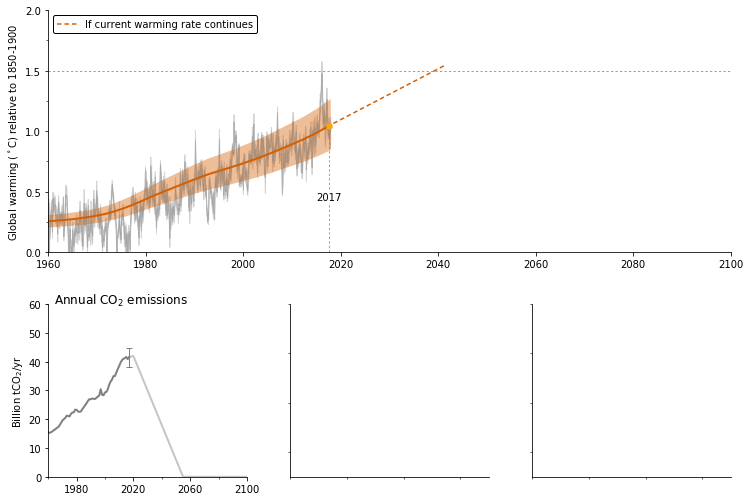

In [7]:
# -----------------------------------------------
# Set axes parameters for left hand subpanel
# -----------------------------------------------
ax_left.tick_params(colors='black'); left_text.set_color('black')  
ax_left.set_ylabel('Billion tCO$_{2}$/yr',fontsize=10)
# -----------------------------------------------


###################################################
### generate annual carbon emissions trajectory ###
###################################################
# Lower non-CO2 forcing trajectory
rf_targs = [0.4]
# zero CO2 emissions by 2055
co2_times_te = np.array([2020,2055,2075])
co2_fracs_te = np.array([1.0,0.0,0.0])

# Find the pathway and save to dictionary 'te'
temp_zero_te, llems_zero_te, slcp_zero_te = linear_decline_tozero(slcp_mode='parab',rf_targs=rf_targs,
                                                                       co2_times=co2_times_te,
                                                                       co2_fracs=co2_fracs_te, 
                                                                       tcrecs_index=[1])

te = {'years':years,'temp_zero':temp_zero_te,'llems_zero':llems_zero_te,'slcp_zero':slcp_zero_te}
###################################################
###################################################

# import GCP carbon emissions data
gcp_data= np.genfromtxt('./Data/gcp_data_2017_prelim.csv',delimiter=',',
        dtype=np.dtype({'names':['Year','FFI','LUC'],'formats':3*[np.float]}))
# total carbon emissions are fossil carbon + LUC
gcp_ems = gcp_data['FFI'] + gcp_data['LUC']

# Add error bar for 2017 annual GCP emissions value
ax_left.errorbar(2017, 44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]==2017], 0.08*44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]==2017], fmt='none',elinewidth=1,ecolor='gray',capsize=3)

# plot annual CO2 emissions on left subpanel
line_1, = ax_left.plot(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],color='grey',linewidth=2, alpha = 0.45)
line_5, = ax_left.plot(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color='grey',linewidth=2)

display(fig)

<br>
<br>

## Add cumulative CO$_2$ emissions trajectory

Plot the cumulative CO$_2$ emissions trajectory on lower middle subplot. Scenario plotted is for zero CO$_2$ emissions in 2055. 

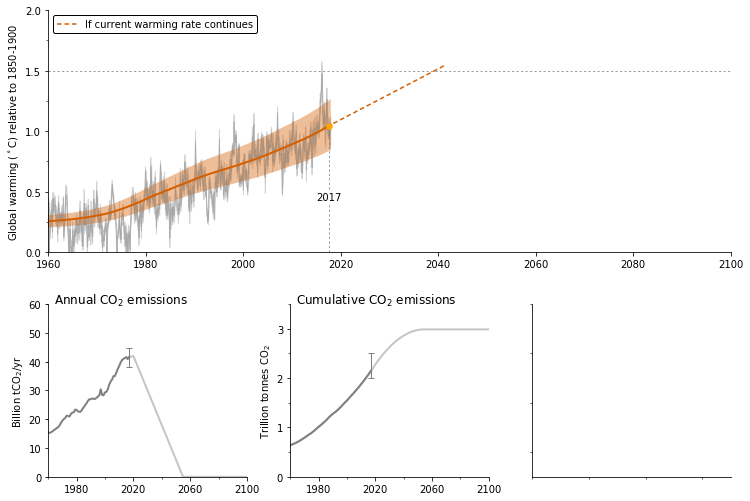

In [8]:
# -----------------------------------------------
# Set axes parameters for middle subpanel
# -----------------------------------------------
ax_middle.tick_params(colors='black'); mid_text.set_color('black')
ax_right.tick_params(colors='white'); right_text.set_color('white')
ax_middle.set_ylabel('Trillion tonnes CO$_2$',fontsize=10); ax_right.set_ylabel('')
# -----------------------------------------------

########################################################
### calculate cumulative carbon emissions trajectory ###
########################################################
# Find the cumulative CO2 emissions pathway by summing the annual emissions trajectory (change units to TtCO2)
cum_high = 44./12000*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
# rebaseline to be zero in 1870
cum_high = cum_high[te['years'][:]>=1950] - cum_high[te['years'][:]==1870]

# get subset of data up to present day (to plot as darker line on subpanel)
x1 = te['years'][:]<=2017
x2 = te['years'][:]>=1950
cum_high_topresentday = 44./12000*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
cum_high_topresentday = cum_high_topresentday[x1*x2] - cum_high_topresentday[te['years'][:]==1870]

# find cumulative GCP emissions and baseline to 1870
gcp_ems[0] = 0
cum_gcp = 44./12000*np.cumsum(gcp_ems)
cum_gcp = cum_gcp[gcp_data['Year']>=1850] - cum_gcp[gcp_data['Year']==1870]

cum_gcp_years = gcp_data['Year'][gcp_data['Year']>=1850]
# Add error bar showing GCP emissions uncertainty in 2017
ax_middle.errorbar(2017, cum_gcp[cum_gcp_years==2017], 0.11*cum_gcp[cum_gcp_years==2017], fmt='none',elinewidth=1,ecolor='gray',capsize=3)
########################################################
########################################################

# add cumulative emissions to middle panel
line_6, = ax_middle.plot(te['years'][te['years'][:]>=1950],cum_high,color='grey',
                        alpha=0.45,linewidth=2)

line_7, = ax_middle.plot(te['years'][x1*x2],cum_high_topresentday,color='grey',linewidth=2)
    
# display figure
display(fig)

<br>
<br>

## Add non-CO$_2$ emissions trajectory

Add the non-CO$_2$ trajectory to the lower righthand subplot. Scenario plotted is for declining non-CO$_2$ climate forcing after 2030. Pre-2017 forcing is from the best estimate forcing, and forcing between 2018 and 2030 follow the shape of the RCP8.5 non-CO$_2$ forcers.

The axes are scaled so that the approximate comparison of cumulative CO$_2$ and non-CO$_2$ climate forcing can be made. 

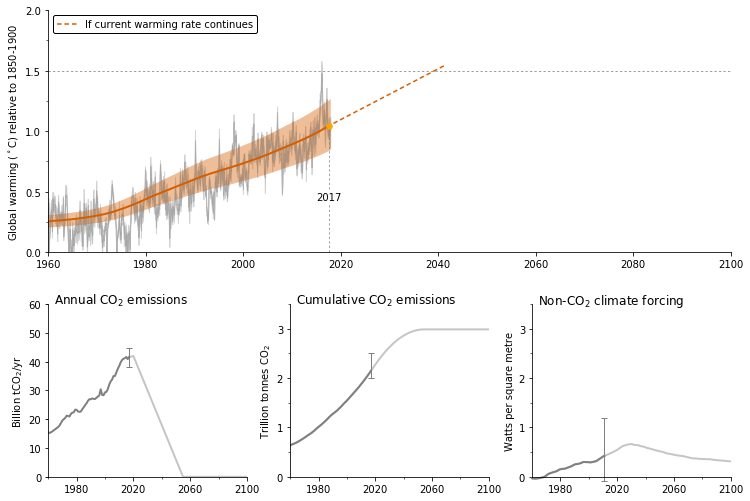

In [9]:
# -----------------------------------------------
# Set axes parameters for right hand subpanel
# -----------------------------------------------
ax_right.tick_params(colors='black'); right_text.set_color('black')
ax_right.set_ylabel('Watts per square metre',fontsize=10)
# -----------------------------------------------

##########################################################
### calculate and add the non-CO2 forcing contribution ###
##########################################################

line_8, = ax_right.plot(te['years'],te['slcp_zero']['RCP8.5'][0][1],color='grey',
                        linewidth=2,alpha = 0.45)

line_9, = ax_right.plot(te['years'][np.logical_and(te['years'][:]<=2011,te['years'][:]>=1960)],
                        te['slcp_zero']['RCP8.5'][0][1][np.logical_and(te['years'][:]<=2011,te['years'][:]>=1960)],
                        color='grey',linewidth=2)

# dont clip line below x-axis
line_9.set_clip_on(False)

#Scale AR5 uncertainty down to likely range 
mu_nco2 = 0.5*(1.13 + 3.33) - 1.68
sig_nco2 = (1.13 - 1.68 - mu_nco2)/(erfinv((0.05)*2 - 1)*np.sqrt(2.0))
nco2_range = sig_nco2 * np.sqrt(2.0) * erfinv(2*(np.array([0.17,0.83])) -1.0) + mu_nco2

# set error bar and allow it to extend below x axis 
#----------------------------------------
e = ax_right.errorbar(2011,mu_nco2,mu_nco2-nco2_range[0],fmt='none',elinewidth=1,ecolor='gray',capsize=3)
for b in e[1]:
    b.set_clip_on(False)
for b in e[2]:
    b.set_clip_on(False)
# -----------------------------------------------

hc_ref = np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=com_ref_low,
                gmst['HadCRUT4']['Years']<(com_ref_high+1))]) - np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=base_low,
                                                gmst['HadCRUT4']['Years']<(base_high+1))])

display(fig)

<br>
<br>

## Add likely temperature response plume 

Finally, we can add the likely temperature response to the future scenario. The plume shapes are calculated in the first line, and then unpacked and plotted below.

fair_scm.py:8: RuntimeWarning: overflow encountered in exp
  iirf100_arr = alpha*(np.sum(a*tau*(1.0 - np.exp(-100.0/(tau*alpha)))))


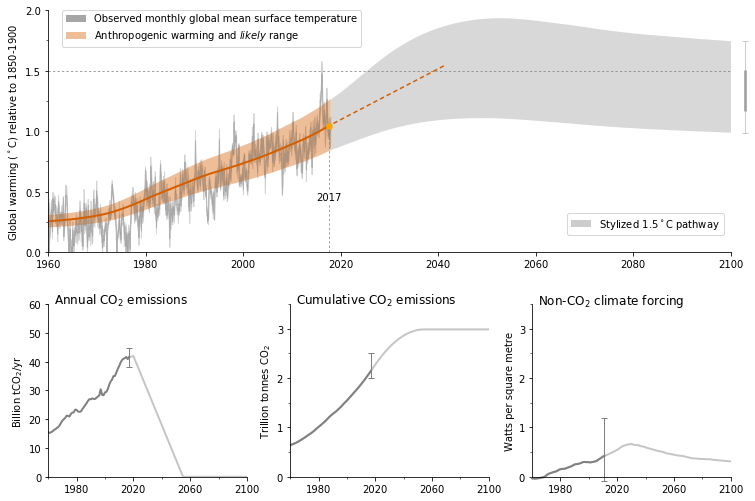

In [10]:
# calculate the required trajectories for TCR/ECS range in central 2/3rds 
te['temp_zero'], te['llems_zero'], te['slcp_zero'] = linear_decline_tozero(slcp_mode='parab',rf_targs=rf_targs,
                                                                                co2_times=np.array([2020,2055,2075]),
                                                                                co2_fracs=np.array([1.0,0.0,0.0]), tcrecs_index=[0,1,2,3,4],
                                                                                temp_zero=te['temp_zero'],llems_zero=te['llems_zero'],
                                                                                slcp_zero=te['slcp_zero'])

# find the relevent ranges for temperature plume
plot_mean = te['temp_zero']['RCP8.5'][0][1] 
plot_uu = te['temp_zero']['RCP8.5'][0][2] 
plot_ll = te['temp_zero']['RCP8.5'][0][0] 
plot_ul = te['temp_zero']['RCP8.5'][0][4] 
plot_lu = te['temp_zero']['RCP8.5'][0][3]


# plot to main temperature panel
plume_23rd = ax_main_fig.fill_between(te['years'][te['years'][:]>2017],
                                   plot_ll[te['years'][:]>2017],plot_uu[te['years'][:]>2017],
                                   color='grey',alpha=0.3,linewidth=0)

# calculate position and size of error bars used to show extent of plumes
#----------------------------------------
dy = (plot_lu[te['years'][:]==2100] - plot_ul[te['years'][:]==2100]) / 2.
y = (plot_lu[te['years'][:]==2100] + plot_ul[te['years'][:]==2100]) / 2.
e1 = ax_main_fig.errorbar(2103, y, yerr=dy, fmt='none', ecolor='grey', alpha=0.6, elinewidth=3, capsize=0)
for b in e1[1]:
    b.set_clip_on(False)
for b in e1[2]:
    b.set_clip_on(False)

dy = (plot_uu[te['years'][:]==2100] - plot_ll[te['years'][:]==2100]) / 2.
y = (plot_uu[te['years'][:]==2100] + plot_ll[te['years'][:]==2100]) / 2.
e11 = ax_main_fig.errorbar(2103, y, yerr=dy, fmt='none', ecolor='grey', alpha=0.4, elinewidth=1, capsize=3)
for b in e11[1]:
    b.set_clip_on(False)
for b in e11[2]:
    b.set_clip_on(False)
#----------------------------------------

# create custom legends for main panel
blue_patch = Patch(facecolor='blue', edgecolor=None, alpha=0.16, label='Faster reductions in CO$_2$ emissions')
red_patch = Patch(facecolor='red', edgecolor=None, alpha=0.16, label='No reductions in non-CO$_2$ climate forcing')
grey_patch = Patch(facecolor='grey', edgecolor=None, alpha=0.4, label='Stylized $1.5^\circ$C pathway')
orange_patch = Patch(facecolor=cols['vermillion'], edgecolor=None, alpha=0.4, label='Anthropogenic warming and $\it{likely}$ range')
grey_patch_2 = Patch(facecolor='grey', edgecolor=None, alpha=0.7, label='Observed monthly global mean surface temperature')

# draw legends to plot
leg_temp_obs = ax_main_fig.legend(handles=[grey_patch], loc=(0.76,0.07),fontsize=10)
ax_main_fig.legend(handles=[grey_patch_2, orange_patch], loc=(0.02,0.85), fontsize=10)
ax_main_fig.add_artist(leg_temp_obs)

# display figure
display(fig)

<br>
<br>

## Adding alternate scenario temperature plumes - higher non-CO$_2$ forcing

Now, we can add the plume exploring the effect of constant non-CO$_2$ forcing contribution. Here CO$_2$ emissions remain on a trajectory with zero CO$_2$ emissions by 2055, and non-CO$_2$ forcing remains constant instead of declining after 2030.

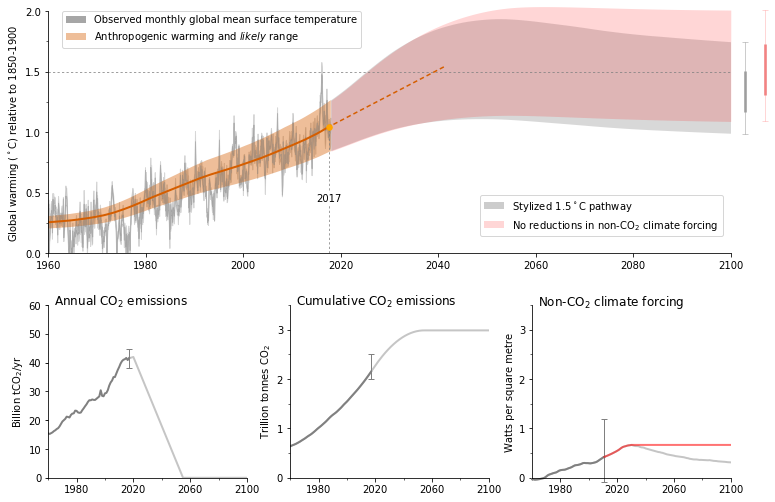

In [11]:
# calculate the required trajectories for TCR/ECS range in central 2/3rds, with constant non-CO2 forcing trajetory after 2030
temp_zero_te2, llems_zero_te2, slcp_zero_te2 = linear_decline_tozero(slcp_mode='parab',rf_targs=[0.8],
                                                                       co2_times=np.array([2020,2055,2075]),
                                                                       co2_fracs=np.array([1.0,0.0,0.0]), 
                                                                       tcrecs_index=[0,1,2,3,4])

# store in different dictionary called 'te2'
te2 = {'years':years,'temp_zero':temp_zero_te2,'llems_zero':llems_zero_te2,'slcp_zero':slcp_zero_te2}

# add the higher non-CO2 forcing trajectory to the right subpanel
ax_right.plot(te2['years'][te2['years']>=2011],te2['slcp_zero']['RCP8.5'][0][1][te2['years']>=2011],color='red',linewidth=2,alpha=0.55)

# find the temeprature responses ranges
plot_uu_nonco2 = te2['temp_zero']['RCP8.5'][0][2] 
plot_lu_nonco2 = te2['temp_zero']['RCP8.5'][0][3]
plot_ll_nonco2 = te2['temp_zero']['RCP8.5'][0][0]
plot_ul_nonco2 = te2['temp_zero']['RCP8.5'][0][4]


# plot plume to main temperature panel
ax_main_fig.fill_between(te2['years'][(te2['years'][:]>2017)*(te2['years'][:]<=2100)],plot_ll_nonco2[(te2['years'][:]>2017)*(te2['years'][:]<=2100)],plot_uu_nonco2[(te2['years'][:]>2017)*(te2['years'][:]<=2100)],
                color='red',linewidth=0,alpha=0.16, clip_on=False)

# calculate position and size of error bars used to show extent of plumes
#----------------------------------------
dy = (plot_lu_nonco2[te['years'][:]==2100] - plot_ul_nonco2[te['years'][:]==2100]) / 2.
y = (plot_lu_nonco2[te['years'][:]==2100] + plot_ul_nonco2[te['years'][:]==2100]) / 2.
e3 = ax_main_fig.errorbar(2107, y, yerr=dy, fmt='none', ecolor=(242/255., 155/255., 155/255.), elinewidth=3, capsize=0)
for b in e3[1]:
    b.set_clip_on(False)
for b in e3[2]:
    b.set_clip_on(False)

dy = (plot_uu_nonco2[te['years'][:]==2100] - plot_ll_nonco2[te['years'][:]==2100]) / 2.
y = (plot_uu_nonco2[te['years'][:]==2100] + plot_ll_nonco2[te['years'][:]==2100]) / 2.
e31 = ax_main_fig.errorbar(2107, y, yerr=dy, fmt='none', ecolor='red', alpha=0.16, elinewidth=1, capsize=3)
for b in e31[1]:
    b.set_clip_on(False)
for b in e31[2]:
    b.set_clip_on(False)
#----------------------------------------

# redraw legends with two plumes on
leg_temp_obs.remove()
leg_temp_obs = ax_main_fig.legend(handles=[grey_patch,red_patch], loc=(0.633,0.07),fontsize=10)
ax_main_fig.legend(handles=[grey_patch_2, orange_patch], loc=(0.02,0.85), fontsize=10)
ax_main_fig.add_artist(leg_temp_obs)

display(fig)

<br>
<br>

## Adding alternate scenario temperature plumes - faster reductions of CO$_2$ emissions

Finally, we add the plume exploring the effect of faster reductions in CO$_2$ emissions. Here CO$_2$ emissions now decline to reach zero in 2040, and non-CO$_2$ climate forcing declines after 2030 (as in grey plume).

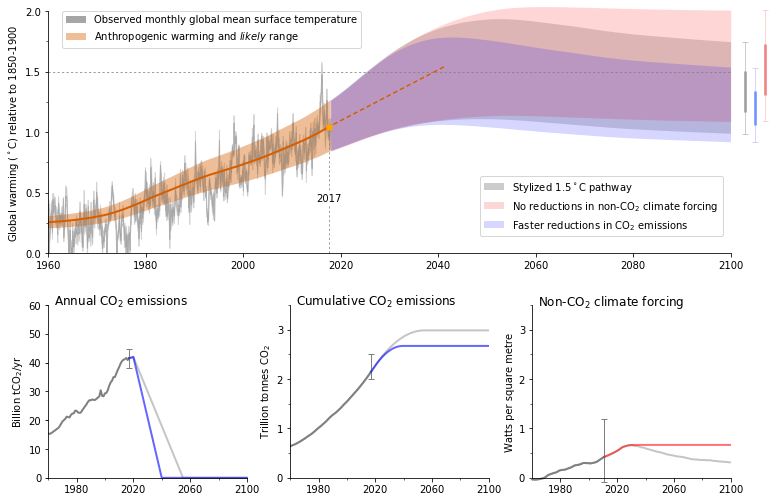

In [12]:
# calculate the required trajectories for TCR/ECS range in central 2/3rds, with faster reductions in CO2 emissions (zero in 2040)
temp_zero_lb, llems_zero_lb, slcp_zero_lb = linear_decline_tozero(slcp_mode='parab',rf_targs=[0.4],
                                                                       co2_times=np.array([2020,2040,2060,2075]),
                                                                       co2_fracs=np.array([1.0,0.0,0.0,0.0]), 
                                                                       tcrecs_index=[0,1,2,3,4])
# store in dictionary called 'lb'
lb = {'years':years,'temp_zero':temp_zero_lb,'llems_zero':llems_zero_lb,'slcp_zero':slcp_zero_lb}

# add the trajectory of CO2 emissions to the left and middle subpanels
values_to_plot = (lb['years'][:]>=2017) * (lb['years'][:]<=2100)
blue_line = ax_left.plot(lb['years'][values_to_plot],44./12*lb['llems_zero']['RCP8.5'][0][1][values_to_plot],color='blue',linewidth=2,alpha=0.6,clip_on=False)
blue_line[0].set_clip_on(False)

cum_low = 44./12000*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]
ax_middle.plot(lb['years'][lb['years'][:]>=2017],cum_low,color='blue',linewidth=2,alpha=0.6)

# find and store the temperature response to 2040-zero-emissions scenario
plot_uu_lowco2 = lb['temp_zero']['RCP8.5'][0][2] 
plot_lu_lowco2 = lb['temp_zero']['RCP8.5'][0][3]
plot_ll_lowco2 = lb['temp_zero']['RCP8.5'][0][0]
plot_ul_lowco2 = lb['temp_zero']['RCP8.5'][0][4]

# plot temperature response to main temperature panel
ax_main_fig.fill_between(lb['years'][lb['years'][:]>2017],plot_ll_lowco2[lb['years'][:]>2017],plot_uu_lowco2[lb['years'][:]>2017],
                color='blue',linewidth=0,alpha=0.16)

# calculate position and size of error bars used to show extent of plumes
#----------------------------------------
dy = (plot_lu_lowco2[te['years'][:]==2100] - plot_ul_lowco2[te['years'][:]==2100]) / 2.
y = (plot_lu_lowco2[te['years'][:]==2100] + plot_ul_lowco2[te['years'][:]==2100]) / 2.
e2 = ax_main_fig.errorbar(2105, y, yerr=dy, fmt='none', ecolor=(142/255., 170/255., 255/255.), elinewidth=3, capsize=0)
for b in e2[1]:
    b.set_clip_on(False)
for b in e2[2]:
    b.set_clip_on(False)

dy = (plot_uu_lowco2[te['years'][:]==2100] - plot_ll_lowco2[te['years'][:]==2100]) / 2.
y = (plot_uu_lowco2[te['years'][:]==2100] + plot_ll_lowco2[te['years'][:]==2100]) / 2.
e21 = ax_main_fig.errorbar(2105, y, yerr=dy, fmt='none', ecolor='blue', alpha=0.16, elinewidth=1, capsize=3)
for b in e21[1]:
    b.set_clip_on(False)
for b in e21[2]:
    b.set_clip_on(False)
#----------------------------------------   

# redraw legends with three plumes on
leg_temp_obs.remove()
leg_temp_obs = ax_main_fig.legend(handles=[grey_patch,red_patch,blue_patch], loc=(0.633,0.07),fontsize=10)
ax_main_fig.legend(handles=[grey_patch_2, orange_patch], loc=(0.02,0.85), fontsize=10)
ax_main_fig.add_artist(leg_temp_obs)

display(fig)

In [17]:
# Save output figures

fig.savefig('./Output/3_plume_SPMfig1.svg', dpi=300)
fig.savefig('./Output/3_plume_SPMfig1.pdf', dpi=300)